In [36]:
!pip install matplotlib tqdm pillow

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

In [21]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

In [2]:
image_dir = '../Data/Picture_Caustic'
mask_dir = '../Data/Caustic_Seg'

image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

# Validate that each image has a corresponding mask
valid_pairs = [(img, img) for img in image_files if img in mask_files]

print(f"Found {len(valid_pairs)} valid image-mask pairs out of {len(image_files)} images.")

Found 1066 valid image-mask pairs out of 1066 images.


In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # Load images and masks into a dictionary
        self.data_dict = self._load_data()
        self.images = list(self.data_dict.keys())

    def _load_data(self):
        data_dict = {}
        image_files = os.listdir(self.image_dir)
        mask_files = os.listdir(self.mask_dir)
        
        for img_name in image_files:
            img_path = os.path.join(self.image_dir, img_name)
            mask_path = os.path.join(self.mask_dir, img_name)
            
            if os.path.exists(mask_path):
                image = Image.open(img_path).convert("RGB")
                mask = Image.open(mask_path).convert("L")
                data_dict[img_name] = (image, mask)
        
        return data_dict

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image, mask = self.data_dict[img_name]
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

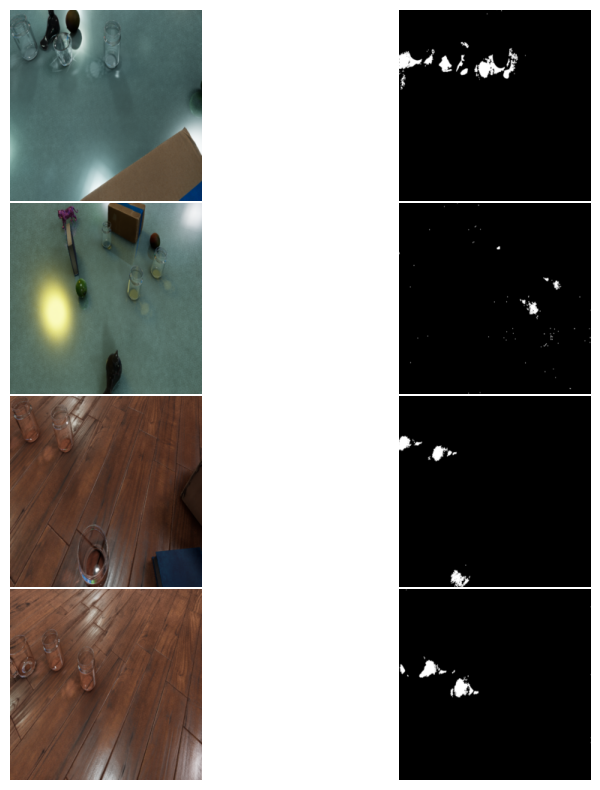

In [5]:
import matplotlib.pyplot as plt

def show_sample_images(dataset, num_samples=4):
    fig, ax = plt.subplots(num_samples, 2, figsize=(10, 10))
    for i in range(num_samples):
        img, mask = dataset[i]
        
        ax[i, 0].imshow(img.permute(1, 2, 0))
        ax[i, 0].axis('off')
        
        ax[i, 1].imshow(mask.squeeze(), cmap='gray')
        ax[i, 1].axis('off')
    
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

show_sample_images(dataset)

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class DownSampleLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSampleLayer, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class UpSampleLayer(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(UpSampleLayer, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DownSampleLayer(64, 128)
        self.down2 = DownSampleLayer(128, 256)
        self.down3 = DownSampleLayer(256, 512)
        self.down4 = DownSampleLayer(512, 512)
        self.up1 = UpSampleLayer(1024, 256)
        self.up2 = UpSampleLayer(512, 128)
        self.up3 = UpSampleLayer(256, 64)
        self.up4 = UpSampleLayer(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
torch.cuda.is_available()

True

In [22]:
# Training Loop with Logging and Progress Bar
def train_model(model, criterion, optimizer, dataloader, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, masks in progress_bar:
            inputs = inputs.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(dataloader.dataset)
        logging.info(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


In [23]:
train_model(model, criterion, optimizer, dataloader, num_epochs=25)

Epoch 1/25: 100%|██████████| 267/267 [00:23<00:00, 11.45it/s, loss=0.0475]
2024-06-23 19:35:35,113 - Epoch 1/25, Loss: 0.0602
Epoch 2/25: 100%|██████████| 267/267 [00:22<00:00, 11.73it/s, loss=0.0279]
2024-06-23 19:35:57,868 - Epoch 2/25, Loss: 0.0587
Epoch 3/25: 100%|██████████| 267/267 [00:22<00:00, 11.72it/s, loss=0.1]   
2024-06-23 19:36:20,645 - Epoch 3/25, Loss: 0.0570
Epoch 4/25: 100%|██████████| 267/267 [00:22<00:00, 11.62it/s, loss=0.0147]
2024-06-23 19:36:43,627 - Epoch 4/25, Loss: 0.0560
Epoch 5/25: 100%|██████████| 267/267 [00:23<00:00, 11.46it/s, loss=0.0358]
2024-06-23 19:37:06,924 - Epoch 5/25, Loss: 0.0544
Epoch 6/25: 100%|██████████| 267/267 [00:23<00:00, 11.39it/s, loss=0.016]  
2024-06-23 19:37:30,366 - Epoch 6/25, Loss: 0.0531
Epoch 7/25: 100%|██████████| 267/267 [00:23<00:00, 11.36it/s, loss=0.0434]
2024-06-23 19:37:53,878 - Epoch 7/25, Loss: 0.0526
Epoch 8/25: 100%|██████████| 267/267 [00:23<00:00, 11.51it/s, loss=0.0143]
2024-06-23 19:38:17,077 - Epoch 8/25, Loss

In [24]:
def visualize_predictions(model, dataloader, num_images=4):
    model.eval()
    images_so_far = 0
    fig, ax = plt.subplots(num_images, 2, figsize=(10, 10))
    with torch.no_grad():
        for i, (inputs, masks) in enumerate(dataloader):
            inputs = inputs.to(device)
            masks = masks.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            
            for j in range(inputs.size()[0]):
                if images_so_far == num_images:
                    return
                ax[images_so_far, 0].imshow(inputs.cpu().data[j].permute(1, 2, 0))
                ax[images_so_far, 1].imshow(preds.cpu().data[j, 0], cmap='gray')
                images_so_far += 1

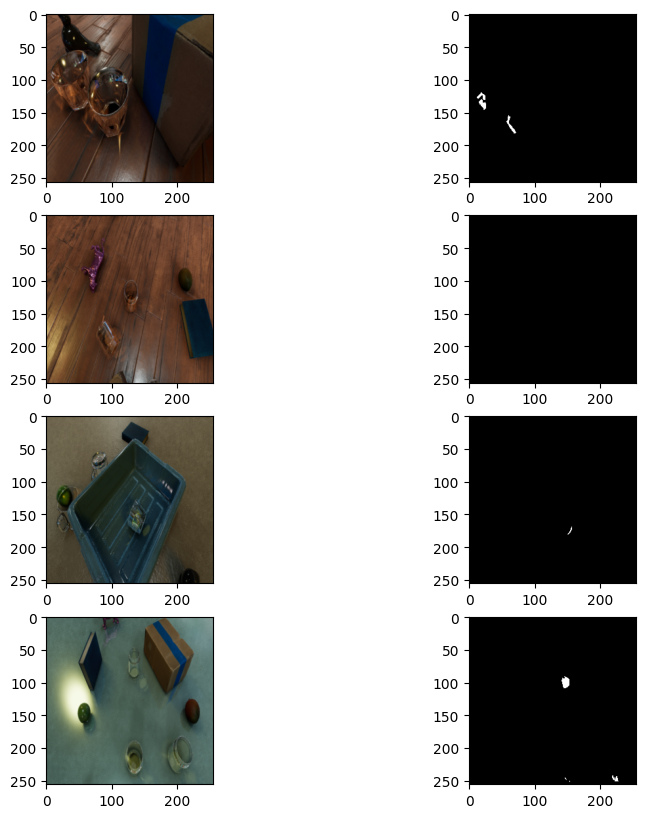

In [25]:
visualize_predictions(model, dataloader)

In [26]:
torch.save(model.state_dict(), 'unet_model.pth')